# Time Series - II (AR Models)

An Auto Regressive (AR) model is a regression which depends linearly on the previous terms. An auto regressive model of order p is a regression model that linearly depends on p previous terms.

$x_{t}$ = $a_{1}$ $x_{t-1}$ + ... + $a_{p}$ $x_{t-p}$ + $w_{t}$

In the above equation, p represents the number of previous terms (lags) used in the model, a is the regressive coefficient and w is the white noise in the term which cannot be explained with the help of previous terms.

In [2]:
#Importing the required packages

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

In [3]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    '''
    Prepares a (3,2) dimensional plot for the visualization of time series values, autocorrelation and partial 
    autocorrelation plots and QQ and probability plots for comparision with normal distribution.
    
    Args:
    y: time series values
    lags: How many lagging values are to be considered.
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)

        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

**Simulating AR(1) process with a = 0.6 **

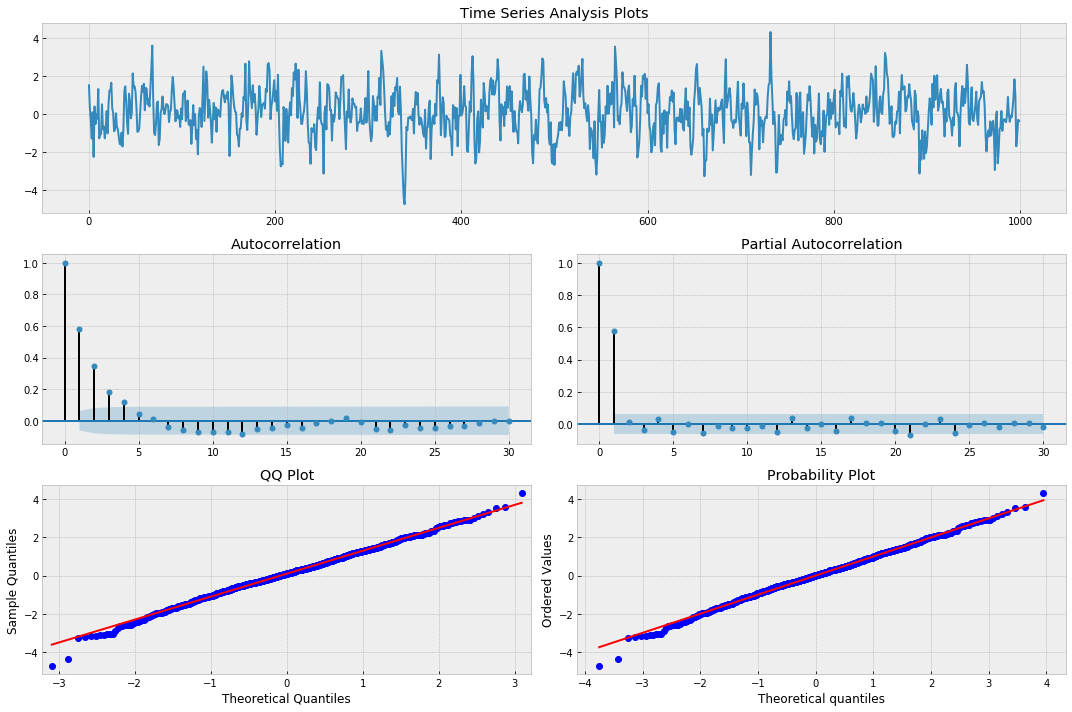

In [4]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

The distribution of our sampled AR1 model data is normal, as it should be as we sampled the data from normal distribution. There is significant correlation between lagged values visible in the ACF plot. 

PACF plots are used to identify the extent of the lag in an autoregressive mode. If we find no significant correlation in a PACF plot after lag $k$, an AR(k) model is usually a good fit. Looking at this chart, we can hypothesize that a AR(1) model should fit.

**Fitting data with Python's statsmodels package **

Now we will use python's statsmodels packages and try to fit an AR model on the data we obtained in the last step to estimate the alpha coefficient and order.

In [5]:
model = sm.tsa.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = sm.tsa.AR(x).select_order( maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: %3.5f | order_estimate %s'%(model.params, est_order))
print('\ntrue alpha = %s | true order = %s'%(a, true_order))


alpha estimate: 0.58227 | order_estimate 1

true alpha = 0.6 | true order = 1


Using statsmodels packages, we have found the value of alpha very near to that of its real value used to generate the data. Also, we were able to identify the order of the AR model accurately.


**Simulating AR(2) process with $a_{1}$ = 0.666 and $a_{2}$ = -0.333**

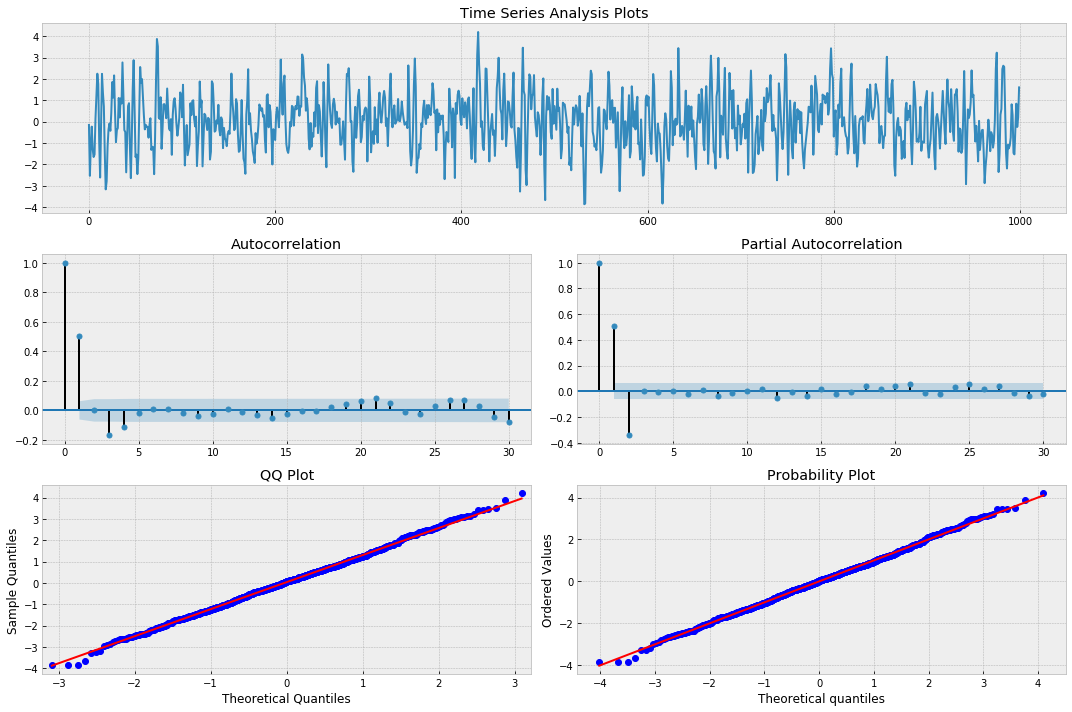

In [6]:
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [7]:
#Fitting the model
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: %3.4f %3.4f | order estimate %s'%(mdl.params[0],mdl.params[1],est_order))


coef estimate: 0.6760 -0.3393 | order estimate 2


In the above models, we are explicitly choosing a lag of 10. If we don't specify the maximum lag that we want to consider, then the model will itself try to estimate the lags. In this process, we will end with estimating many more lags than the actual case because of indirect dependencies (see below). For Example, our AR(1) model just depends on the previous value $x_{t}$ (lag = 1), but model will include many more lags as $x_{t}$ depends on $x_{t-1}$ and in turn $x_{t-2}$ and so on indirectly.

This inclusion of indirect dependencies is not a good thing, as we want to have as few parameters in the model as possible. Including all the parameters overfit the data. 

#Naive fit of the model

model2 = smt.AR(ar2).fit()
print('Parameters')
print(model2.params)
print('Standard Error')
print(model2.bse)

By observing the ACF and PACF plots, we can infer that first two lags are useful. We can also AIC (Akaike Information Criterion) to test the useful lags. Python does that for usu when we use 'maxlags' and 'ic' arguments in the fit() function.  We want a model with smallest AIC, so we compute the AIC for all the models that we want to consider and we select the model with the smallest AIC. This model minimizes the information loss and select the best number of parameters.


In [10]:
N = 10
AIC = np.zeros((N,1))

for i in range(N):
    model = smt.AR(ar2)
    model = model.fit(maxlag = (i+1))
    AIC[i] = model.aic

AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print("Minimum number of parameters in minimum AIC model %s" %(model_min + 1))

Minimum number of parameters in minimum AIC model 2


**Evaluating Residuals **

The final step after fitting the model is to evaluate its residual behaviour. We want out residuals to be white noise because if it is not then that means there is still some pattern in it which could be extracted and there is a scope of making our model better.

The residuals seem normally distributed.


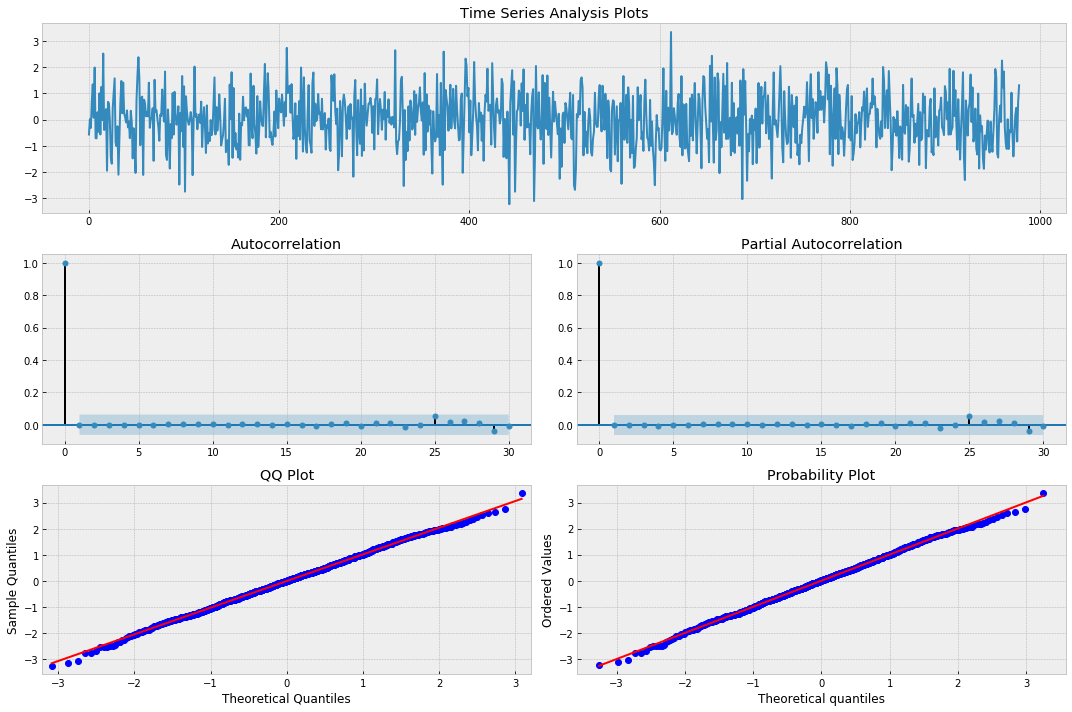

In [16]:
# Checking the normality of the residuals

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')
    
tsplot(model2.resid, lags=30)

The residuals looks like randomly distributed in the first plot, indicating that the model explains the data well.